In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [1]:
IMG_SIZE = 224
BATCH_SIZE = 50
BUFFER_SIZE = 500

In [7]:
#Train and Test data
data, metadata = tfds.load('cifar10', with_info=True,as_supervised=True)
raw_train, raw_test = data['train'], data['test']


In [8]:
# prepare Train data
def train_data_sample(image, label):
  """Transform data for training"""
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = (image / 127.5) - 1
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  label = tf.one_hot(label,metadata.features['label'].num_classes)
  return image, label

In [9]:
# prepare Test data
def test_data_sample(image, label):
  """Transform data for testing"""
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = (image / 127.5) - 1
  label = tf.one_hot(label,metadata.features['label'].num_classes)
  return image, label

In [15]:
# assign transformers to raw data
train_dataset = raw_train.map(train_data_sample, num_parallel_calls=tf.data.AUTOTUNE)
#train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_batches = train_dataset.repeat() # Repeat for training epochs

test_dataset = raw_test.map(test_data_sample, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# using a pretrain model and change the last layer with Averagepooling
# and a fully connected layer
def build_model():
  base_model = tf.keras.applications.ResNet50V2(input_shape= (IMG_SIZE,IMG_SIZE,3),
                                                include_top=False, weights ='imagenet')
  base_model.trainable = False
  #build new model
  return tf.keras.Sequential([base_model, tf.keras.layers.AveragePooling2D(pool_size=2),tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units =metadata.features['label'].num_classes,
                                                   activation=tf.keras.activations.softmax)])

In [12]:
def build_fine_tunning_model():
  base_model = tf.keras.applications.ResNet50V2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                                include_top =False, weights = 'imagenet')

  #freeze the parameters of all layers before layer 100,
  #only update the parameters (weights) of layer 100 and every layer after it during training
  fine_tune_at = 100
  for layer in base_model.layers[:fine_tune_at]:
       layer.trainable = False

  # build a new model
  return tf.keras.Sequential([base_model,tf.keras.layers.AveragePooling2D(pool_size=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(metadata.features['label'].num_classes,
                                                   activation ='softmax')])




In [13]:
def train_model (model, epochs=5):

  model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate= 0.0001),
                loss='categorical_crossentropy',metrics=['accuracy'])
  history = model.fit(train_batches,epochs=epochs, steps_per_epoch=metadata.splits['train'].num_examples // BATCH_SIZE,
                    validation_data=test_batches,
                    validation_steps=metadata.splits['test'].num_examples // BATCH_SIZE, verbose=1)
  test_acc = history.history['val_accuracy']
  print("test accuracy=", test_acc)
  plt.figure()
  plt.plot(test_acc)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()


Epoch 1/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 274s 246ms/step - accuracy: 0.7326 - loss: 0.8170 - val_accuracy: 0.8996 - val_loss: 0.2990
Epoch 2/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 242s 242ms/step - accuracy: 0.9097 - loss: 0.2724 - val_accuracy: 0.9033 - val_loss: 0.2938
test accuracy= [0.8996000289916992, 0.9032999873161316]


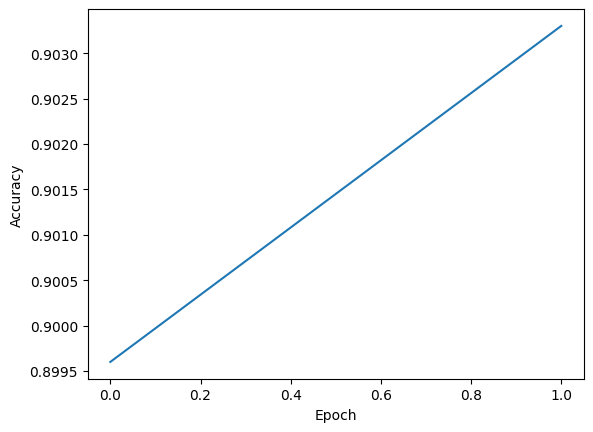

Epoch 1/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 126ms/step - accuracy: 0.6166 - loss: 1.2873 - val_accuracy: 0.8227 - val_loss: 0.5500
Epoch 2/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 122ms/step - accuracy: 0.8052 - loss: 0.6010 - val_accuracy: 0.8402 - val_loss: 0.4982
test accuracy= [0.822700023651123, 0.8402000069618225]


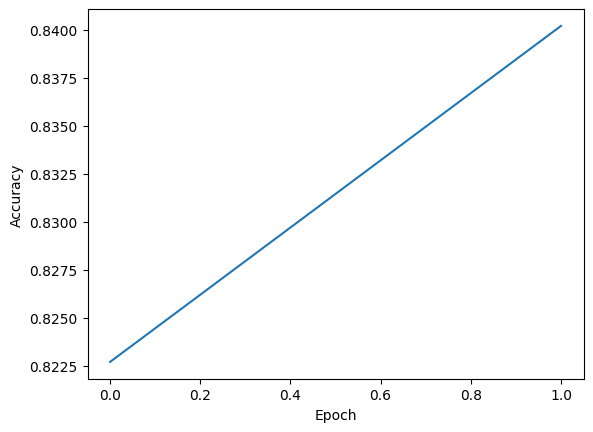

In [16]:
#compare fine_tunning and build model
train_model(build_fine_tunning_model(),2)
train_model(build_model(),2)